## 验证模型
**学习内容：**
我们将对之前的加州房价预测模型进行改进，包括但不限于：
- 使用更多的特征提高模型的有效性
- 调试模型输入数据中的问题
- 使用测试数据集检查模型是否过拟合验证数据

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

# 打乱样本
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

/Users/kevin/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# 预处理特征
def preprocess_features(california_housing_df):
    """预处理房价的DataFrame，准备输入特征,添加人为特征
    Args:
        california_housing_df: 包含加州房价数据的df
    Returns:
        包含处理后特征的DataFrame
    """
    selected_features = california_housing_df[["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    # 创建额外的特征
    processed_features["rooms_per_person"] = (california_housing_df["total_rooms"] / california_housing_df["population"])
    return processed_features

# 预处理目标
def preprocess_targets(california_housing_df):
    """从加州房价DataFrame准备目标特征，即标签
    Args:
        california_housing_dataframe: 包含加州房价数据的df
    Returns:
        包含目标标签的df
    """
    output_targets = pd.DataFrame()
    # 将目标标签的值缩放
    output_targets["median_house_value"] = (california_housing_df["median_house_value"] / 1000.0)
    return output_targets

### 构建训练集

In [3]:
# 构建训练集样本
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2637.0,538.9,1428.0,500.4,3.9,2.0
std,2.1,2.0,12.6,2152.5,420.8,1152.6,382.9,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.8,296.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,434.0,1168.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3149.2,648.2,1724.0,606.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


In [4]:
# 构建训练集目标
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.7
std,116.2
min,15.0
25%,120.1
50%,180.4
75%,265.3
max,500.0


### 构建验证集

In [5]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.5,2659.7,540.7,1433.4,503.1,3.9,2.0
std,2.1,2.0,12.5,2244.6,423.2,1136.6,388.5,1.9,1.0
min,32.5,-124.2,1.0,8.0,1.0,13.0,1.0,0.5,0.2
25%,33.9,-121.8,18.0,1463.0,297.0,786.0,280.8,2.6,1.5
50%,34.3,-118.5,28.0,2123.5,432.0,1163.5,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3155.0,648.2,1717.2,603.0,4.8,2.3
max,41.9,-114.6,52.0,37937.0,5471.0,16122.0,5189.0,15.0,26.5


In [6]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,206.3
std,115.4
min,15.0
25%,118.5
50%,180.1
75%,264.3
max,500.0


### 任务1. 检查数据
可以结合统计学背景或常识对数据的合理性进行检验。
- 值是否处于合理的范围？
- 值是否存在？
- 值的单位或尺度是否明确？
- 有的值过于离谱？数据是否损坏？

### 任务2. 数据可视化
我们针对于加州房价数据中的经纬度信息，来对数据进行可视化。

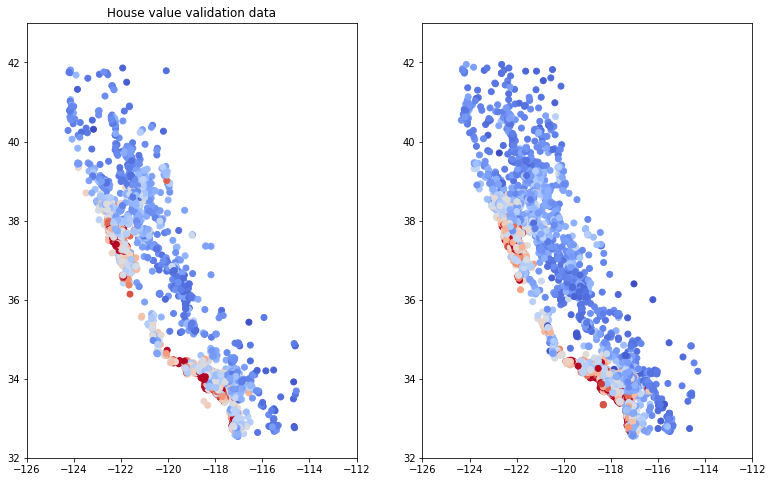

In [7]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("House value validation data")
ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],validation_examples["latitude"],
            cmap="coolwarm",c=validation_targets["median_house_value"]/validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],training_examples["latitude"],
            cmap="coolwarm",c=training_targets["median_house_value"]/training_targets["median_house_value"].max())
_ = plt.plot()

**注意**: 我们可以发现，左侧验证集和右侧训练集的分布并不一致，我们应当考虑是不是数据集分割的方式存在问题。  
我们需要对数据进行随机打乱。  
机器学习中的调试常常是数据调试而不是代码调试。

### 任务3. 训练和评估模型
与之前的任务不同，这次我们用所有的特征训练模型。

In [8]:
def my_input_fn(features, targets, batch_size=1,shuffle=True, num_epochs=None):
    """使用多个特征训练一个线性回归器
    Args:
        features: 特征的DataFrame
        targets: 目标的DataFrame
        batch_size: 传递给模型的批大小
        shuffle: 是否打乱数据
        num_epochs: 数据重复的epochs数
    Returns:
        下一批数据元组(features, labels)
    """
    # 转换DataFrame到numpy数组
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # 构建数据集
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # 打乱数据
    if shuffle:
        ds = ds.shuffle(10000)
        
    # 返回下一批数据
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

我们现在输入了多个特征，我们需要把特征列配置为独立的函数并模块化，数值特征构建比较简单。

In [9]:
def construct_feature_columns(input_features):
    """构建特征列
    Args:
        input_features: 数值特征的名字
    Returns:
        特征列集
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

使用一些方法检查数据：
- 比较预测值和实际值的分布情况
- 绘制预测值和目标值的散点图

In [10]:
def train_model(learning_rate, 
                steps, 
                batch_size, 
                traning_examples, 
                training_targets, 
                validation_examples, 
                validation_targets):
    """使用多个特征训练一个线性回归模型
    """
    periods = 10
    steps_per_period = steps / periods
    
    # 定义优化器
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    # 创建一个线性回归器
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), 
                                                    optimizer=my_optimizer)
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)
    
    # 训练模型，并在每个周期输出loss
    print("Start training...")
    print("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # 计算预测
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
        
        # 计算训练和验证的损失
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # 输出结果
        print("period %02d : %.2f" % (period, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished!")
    
    # 损失随周期变化图
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error via Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validaiton")
    plt.legend()
    
    return linear_regressor

Start training...
RMSE (on training data): 
period 00 : 166.76
period 01 : 168.92
period 02 : 173.76
period 03 : 171.95
period 04 : 174.12
period 05 : 176.13
period 06 : 177.15
period 07 : 170.07
period 08 : 174.44
period 09 : 173.57
Model training finished!


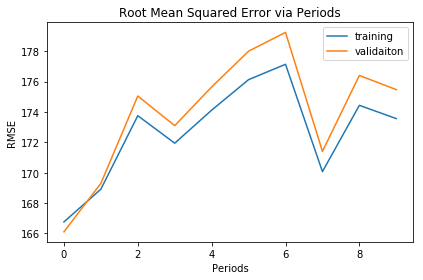

In [14]:
trained_linear_regressor = train_model(learning_rate=0.0001, steps=1000, batch_size=5, 
                                       traning_examples=training_examples, 
                                       training_targets=training_targets,
                                       validation_examples=validation_examples,
                                      validation_targets=validation_targets)

### 任务4. 使用测试数据
数据地址：https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv

In [12]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda:my_input_fn(test_examples, test_targets["median_house_value"], num_epochs=1, shuffle=False)

test_predictions = trained_linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item["predictions"][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))
print("Test RMSE: %.2f" % root_mean_squared_error)

Test RMSE: 173.30
